# Introduction
In the following you will see how to read the provided files for the mini-project 3.
First you will see how to read each of the provided files. Then, you will see a more elegant way of using this data for training neural networks.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive' )

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%cd '/content/gdrive/My Drive/Comp4900A3'
!ls './data/'

/content/gdrive/My Drive/Comp4900A3
NewTest.pkl   temptestlabels.csv  TrainLabels.csv
NewTrain.pkl  Test.pkl		  Train.pkl


In [0]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch
import math

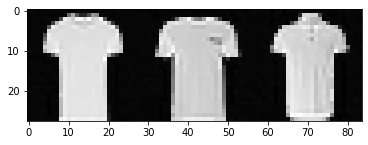

In [0]:
# Read a pickle file and disply its samples
# Note that image data are stored as unit8 so each element is an integer value between 0 and 255
data = pickle.load( open( './data/NewTrain.pkl', 'rb' ), encoding='bytes')
targets = np.genfromtxt('./data/TrainLabels.csv', delimiter=',')
plt.imshow(data[1234,:,:],cmap='gray', vmin=0, vmax=256)

# Dataset class
*Dataset* class and the *Dataloader* class in pytorch help us to feed our own training data into the network. Dataset class is used to provide an interface for accessing all the training or testing samples in your dataset. For your convinance, we provide you with a custom Dataset that reads the provided data including images (.pkl file) and labels (.csv file).

# Dataloader class
Although we can access all the training data using the Dataset class, for neural networks, we would need batching, shuffling, multiprocess data loading, etc. DataLoader class helps us to do this. The DataLoader class accepts a dataset and other parameters such as batch_size.

In [0]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.RandomErasing(p=0.5,ratio=(0.5,2.0)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [0]:


class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',')
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.astype('uint8'), mode='L')

        if self.transform is not None:
           img = self.transform(img)

        return img, target

In [0]:
# Read image data and their label into a Dataset class
dataset = MyDataset('./data/NewTrain.pkl', './data/TrainLabels.csv',transform=img_transform, idx=None)
train_set, val_set = torch.utils.data.random_split(dataset, [59999, 1])

batch_size = 256 #feel free to change it
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [0]:

device = 'cuda' #CUDA is GPU

In [0]:
import torch.nn as nn
import torch.nn.functional as F
#code from:
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
# https://github.com/zhunzhong07/Random-Erasing/blob/master/models/fashion/resnet.py

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, depth=20, num_classes=10):
        super(ResNet, self).__init__()
        # Model type specifies number of layers for CIFAR-10 model
        assert (depth - 2) % 6 == 0, 'depth should be 6n+2'
        n = int((depth - 2) / 6)

        block = Bottleneck if depth >=44 else BasicBlock

        self.inplanes = 32
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, n) #maybe this should have been 32
        self.layer2 = self._make_layer(block, 128, n, stride=2)
        self.layer3 = self._make_layer(block, 256, n, stride=2)
        # self.avgpool = nn.AvgPool2d(7)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256 * block.expansion, 220)
        self.fc2 = nn.Linear(220, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)    

        x = self.layer1(x)  
        x = self.layer2(x) 
        x = self.layer3(x)  

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [0]:
net = ResNet(num_classes=10,depth=32)
net.to(device)
import torch.optim as optim

criterion = nn.CrossEntropyLoss()



In [0]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In [0]:
# valloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
trainingloss = []
for epoch in range(400):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()

    print('[%d] training loss: %.5f' % (epoch + 1, running_loss / i))
    trainingloss.append(running_loss / i)

    if epoch == 99:
      PATH = './saved_models/resnet6_100epochs.pth'
      torch.save(net.state_dict(), PATH)
    if epoch == 199:
      PATH = './saved_models/resnet6_200epochs.pth'
      torch.save(net.state_dict(), PATH)
    if epoch == 299:
      PATH = './saved_models/resnet6_300epochs.pth'
      torch.save(net.state_dict(), PATH)
    if epoch == 399:
      PATH = './saved_models/resnet6_400epochs.pth'
      torch.save(net.state_dict(), PATH)
        
    
    if epoch == 150:
      for param_group in optimizer.param_groups:
          param_group['lr'] = 0.01 
    if epoch == 225:
      for param_group in optimizer.param_groups:
          param_group['lr'] = 0.001 
    if epoch == 300:
      for param_group in optimizer.param_groups:
          param_group['lr'] = 0.0005 

print('Finished Training')


[1] training loss: 1.91742
[2] training loss: 0.85378
[3] training loss: 0.62430
[4] training loss: 0.52749
[5] training loss: 0.46508
[6] training loss: 0.41975
[7] training loss: 0.38586
[8] training loss: 0.35339
[9] training loss: 0.33643
[10] training loss: 0.31597
[11] training loss: 0.29343
[12] training loss: 0.27653
[13] training loss: 0.25810
[14] training loss: 0.24386
[15] training loss: 0.23360
[16] training loss: 0.21957
[17] training loss: 0.20874
[18] training loss: 0.19928
[19] training loss: 0.18786
[20] training loss: 0.17694
[21] training loss: 0.16544
[22] training loss: 0.16192
[23] training loss: 0.15734
[24] training loss: 0.15012
[25] training loss: 0.14190
[26] training loss: 0.13617
[27] training loss: 0.13479
[28] training loss: 0.12626
[29] training loss: 0.12612
[30] training loss: 0.11880
[31] training loss: 0.10823
[32] training loss: 0.11005
[33] training loss: 0.10698
[34] training loss: 0.10518
[35] training loss: 0.10058
[36] training loss: 0.09741
[

In [0]:
testdata = MyDataset('./data/NewTest.pkl','./data/temptestlabels.csv',transform=test_transform, idx=None)
testloader = DataLoader(testdata, batch_size=batch_size, shuffle=False)

(10000, 28, 84)


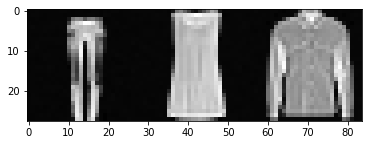

In [0]:
tempdata = pickle.load( open( './data/NewTest.pkl', 'rb' ), encoding='bytes')
print(tempdata.shape)
plt.imshow(tempdata[5555],cmap='gray', vmin=0, vmax=256)

In [0]:
correct = 0
total =0
loopcount=0
preds = []
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        preds.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loopcount+=1
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 0 %


In [0]:
import numpy as np
preds = np.concatenate(preds,axis=0)

In [0]:
import pandas as pd
indexlist = list(range(0,10000))
df = pd.DataFrame(list(zip(indexlist, preds)), 
               columns =['id', 'output']) 

df.to_csv("./Submissions/resnet34morefilters_200epochs.csv",index=False)